<a href="https://colab.research.google.com/github/Nazneen-akram/NED-DL-Assignments/blob/main/Assignment_2_C_V_Classification_Low_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os, pathlib,shutil
import numpy as np
import time

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D


import matplotlib.pyplot as plt
import seaborn as sns

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

-- from Kaggle

In [2]:
from google.colab import files
files.upload()    # you will chose file for your kaggle.json, downloaded from laggle/settings

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazneenakram","key":"08d579900181a0e53c4bac39e23b069d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d carlosrunner/pizza-not-pizza

 88% 89.0M/101M [00:00<00:00, 195MB/s]
100% 101M/101M [00:00<00:00, 170MB/s] 


The Data Extraction

In [5]:
!unzip pizza-not-pizza.zip && rm -rf pizza-not-pizza.zip

Archive:  pizza-not-pizza.zip
  inflating: pizza_not_pizza/food101_subset.py  
  inflating: pizza_not_pizza/not_pizza/1005746.jpg  
  inflating: pizza_not_pizza/not_pizza/1009225.jpg  
  inflating: pizza_not_pizza/not_pizza/1012312.jpg  
  inflating: pizza_not_pizza/not_pizza/1018802.jpg  
  inflating: pizza_not_pizza/not_pizza/1020735.jpg  
  inflating: pizza_not_pizza/not_pizza/1027142.jpg  
  inflating: pizza_not_pizza/not_pizza/102839.jpg  
  inflating: pizza_not_pizza/not_pizza/1043233.jpg  
  inflating: pizza_not_pizza/not_pizza/1045400.jpg  
  inflating: pizza_not_pizza/not_pizza/104773.jpg  
  inflating: pizza_not_pizza/not_pizza/1050956.jpg  
  inflating: pizza_not_pizza/not_pizza/1054362.jpg  
  inflating: pizza_not_pizza/not_pizza/1062097.jpg  
  inflating: pizza_not_pizza/not_pizza/1066151.jpg  
  inflating: pizza_not_pizza/not_pizza/1070772.jpg  
  inflating: pizza_not_pizza/not_pizza/1070867.jpg  
  inflating: pizza_not_pizza/not_pizza/107499.jpg  
  inflating: pizza_not_

**Copying images to training, validation, and test directories**

In [48]:
# Define the directories
data_dir = pathlib.Path('pizza_not_pizza')
pizza_dir = data_dir / 'pizza'
not_pizza_dir = data_dir / 'not_pizza'

In [49]:
class_names = []
for f in data_dir.rglob('*'):
  if f.is_dir():
    class_names.append(str(f).rsplit('/')[-1])

class_names

['not_pizza', 'pizza']

In [50]:
# Count the number of files (i.e., images) in each directory
pizza_count = len(list(pizza_dir.glob('*')))
not_pizza_count = len(list(not_pizza_dir.glob('*')))

print(f"There are {pizza_count} pizza images and {not_pizza_count} not pizza images.")

There are 983 pizza images and 983 not pizza images.


### Data preprocessing

In [51]:
# Defining data generator without Data Augmentation. Normalize the pixel values of input images,
data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

train_ds = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary'
                                          )
valid_ds = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary'
                                        )

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


### Data Visualisation

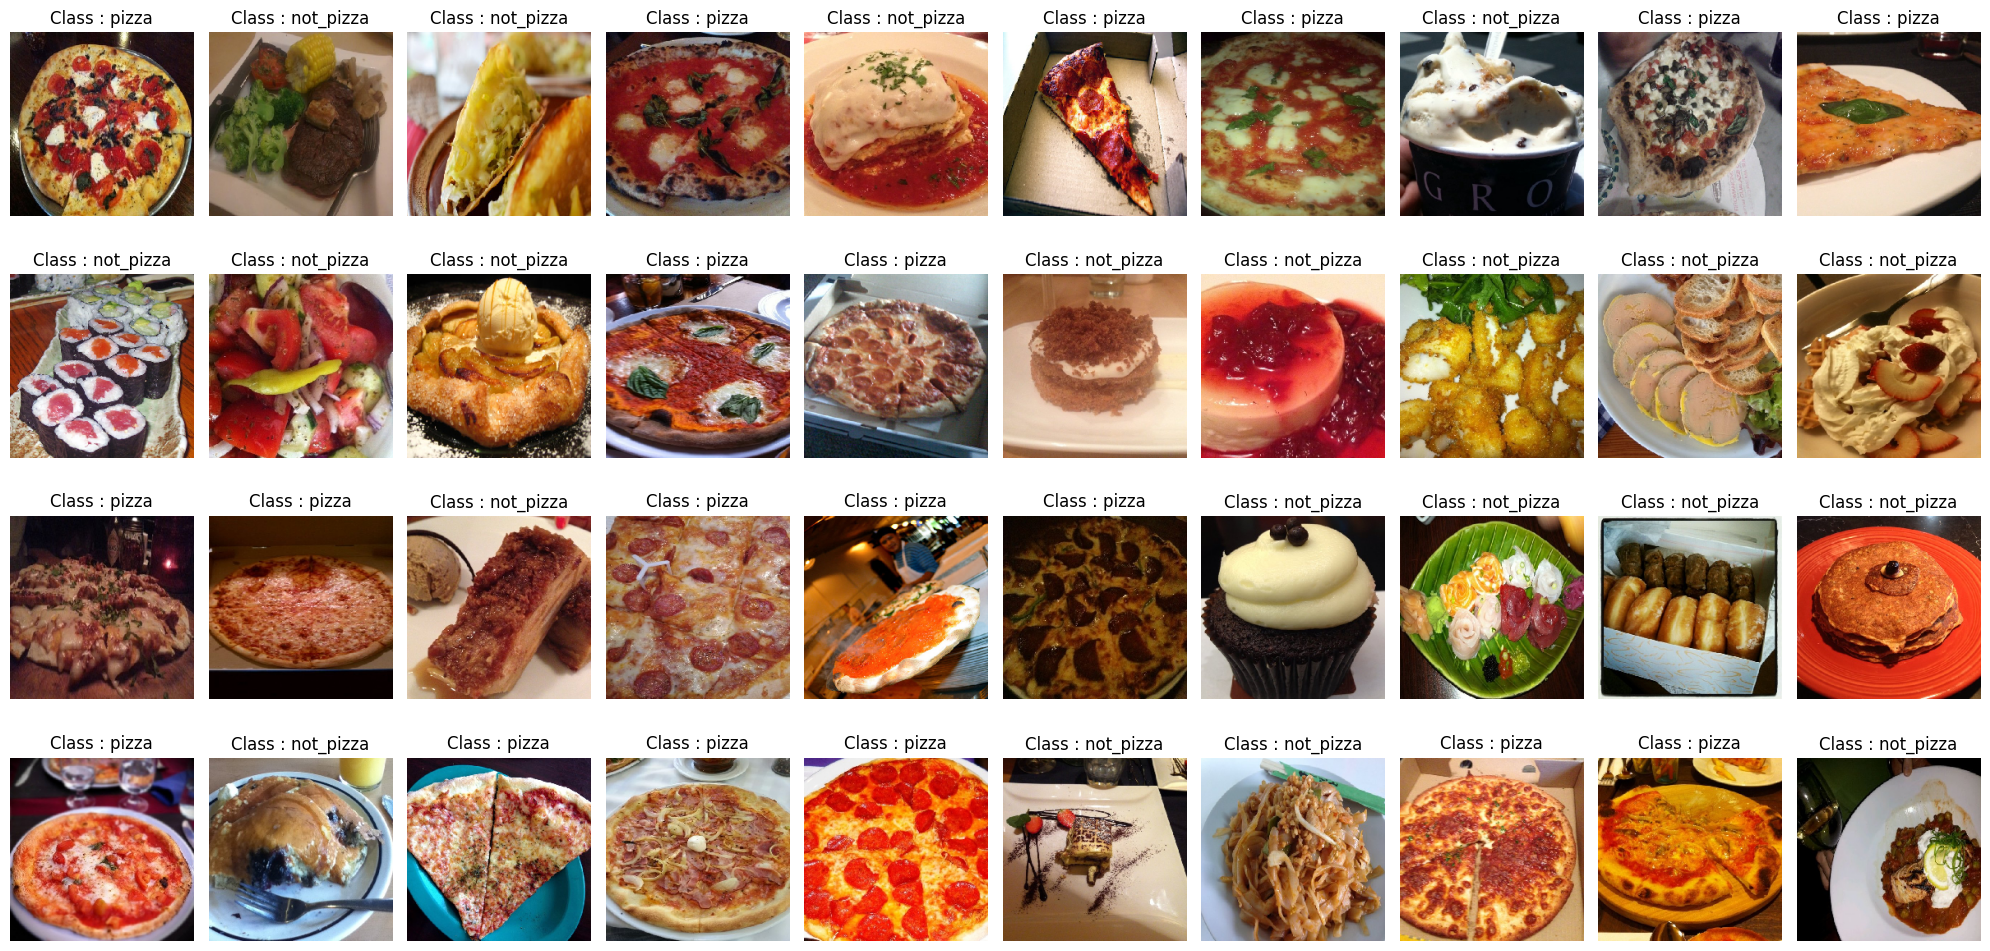

In [52]:
i=1
plt.figure(figsize=(20,10))
for images, labels in train_ds:

    id = np.random.randint(len(images))
    image, label = images[id], int(labels[id])

    plt.subplot(4,10,i)
    plt.imshow(image)
    plt.title(f"Class : {class_names[label]}")
    plt.axis('off')

    i+=1
    if i>=41:
        break
plt.tight_layout()
plt.show()

### Building the model (Simple CNN)

**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [53]:
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


**Instantiating a small convnet for pizza vs. not pizza classification**

In [54]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer. 224x224 pixels and 3 color channels (typically representing Red, Green, and Blue)
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer
])

In [55]:
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      4128      
                                                                 
 flatten_6 (Flatten)         (None, 1577088)           0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1577089   
                                                                 
Total params: 1581633 (6.03 MB)
Trainable params: 1581633 (6.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Store the number of trainable parameters in a variable
train_param_model_1 = model_1.count_params()

print(f'The number of trainable parameters in Model 1 is: {train_param_model_1}')

The number of trainable parameters in Model 1 is: 1581633


**Configuring the model for training**

In [57]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

**Fitting the model using a `Dataset`**

In [58]:
# Start time
start_time_history_1 = time.time()

history_1 = model_1.fit(train_ds,
                        epochs= 5,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds))

# End time
end_time_history_1 = time.time()

Epoch 1/5
50/50 [==============================] - 7s 113ms/step - loss: 3.1978 - accuracy: 0.4886 - val_loss: 0.6974 - val_accuracy: 0.5026
Epoch 2/5
50/50 [==============================] - 7s 133ms/step - loss: 0.6110 - accuracy: 0.6518 - val_loss: 0.5988 - val_accuracy: 0.7245
Epoch 3/5
50/50 [==============================] - 6s 111ms/step - loss: 0.3765 - accuracy: 0.8475 - val_loss: 0.5494 - val_accuracy: 0.7296
Epoch 4/5
50/50 [==============================] - 8s 154ms/step - loss: 0.1732 - accuracy: 0.9498 - val_loss: 0.6901 - val_accuracy: 0.6913
Epoch 5/5
50/50 [==============================] - 7s 149ms/step - loss: 0.0680 - accuracy: 0.9898 - val_loss: 0.7255 - val_accuracy: 0.6786


In [59]:
# Calculate the training time
train_time = end_time_history_1 - start_time_history_1

print(f'The training time of the model is: {train_time:.2f} seconds')

The training time of the model is: 39.52 seconds


**Displaying curves of loss and accuracy during training**

In [60]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

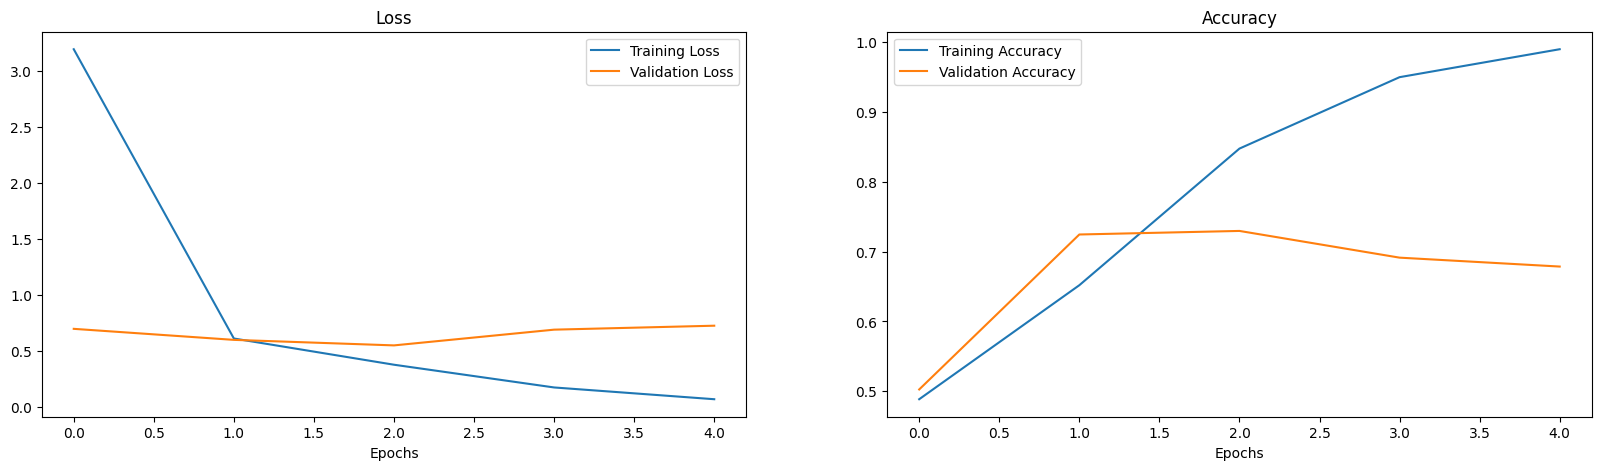

In [61]:
plot_loss_curves(history_1)

In [62]:
model_1.save('convnet_from_scratch.keras')

In [63]:
from keras.saving import load_model

test_model = load_model('convnet_from_scratch.keras')

**Evaluating the model on the test set**

In [64]:
test_loss_model_1, test_acc_model_1 = test_model.evaluate(valid_ds)
print(f"Test accuracy: {test_acc_model_1:.3f}")

13/13 [==============================] - 1s 83ms/step - loss: 0.7255 - accuracy: 0.6786
Test accuracy: 0.679


### 2. Simple CNN with data augmentation

**Define a data augmentation stage to add to an image model**

In [19]:
# Defining data generator with Data Augmentation
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
   ])

**Displaying some randomly augmented training images**

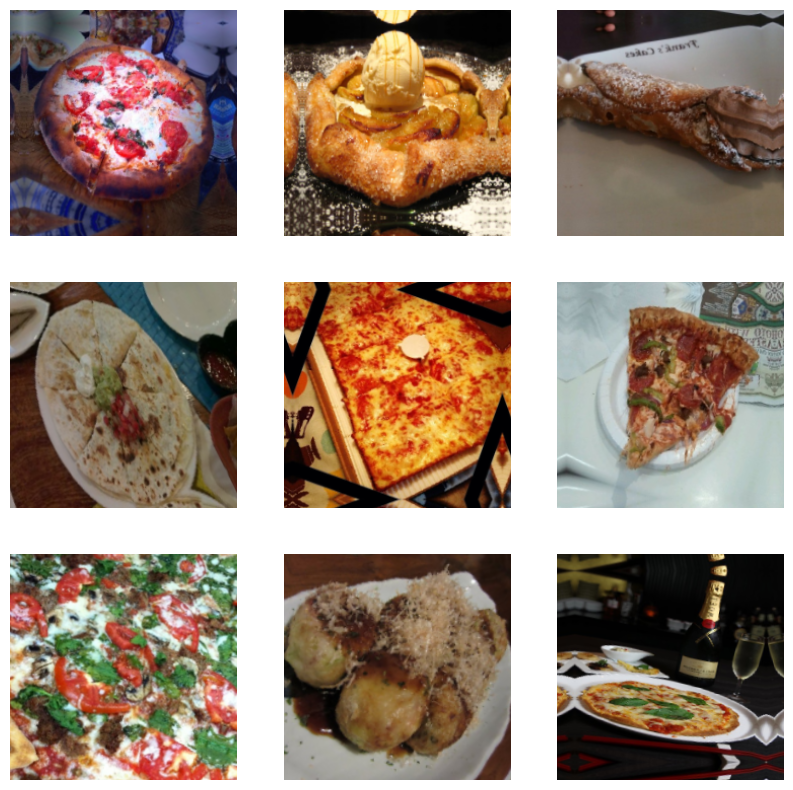

In [25]:
plt.figure(figsize=(10, 10))
images, _ = next(train_ds)
for i in range(9):
  # Apply data augmentation
  augmented_images = data_augmentation(images[i][None, ...])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0])
  plt.axis("off")

**Displaying count of Augmented training images**

In [65]:
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              subset = 'training',
                                                              class_mode = 'binary')

print('Unchanged Validation Images:')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 1574 images belonging to 2 classes.
Unchanged Validation Images:
Found 392 images belonging to 2 classes.


**Defining a new convnet that includes image augmentation**

In [66]:
# Start time
start_time_history_2 = time.time()

history_2 = model_1.fit(train_data_augmented, # changing the training data
                        epochs= 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data,
                        validation_steps = len(val_data))

# End time
end_time_history_2 = time.time()

Epoch 1/5
50/50 [==============================] - 27s 531ms/step - loss: 0.6877 - accuracy: 0.6099 - val_loss: 0.6496 - val_accuracy: 0.5995
Epoch 2/5
50/50 [==============================] - 23s 463ms/step - loss: 0.6531 - accuracy: 0.6252 - val_loss: 0.6336 - val_accuracy: 0.6378
Epoch 3/5
50/50 [==============================] - 26s 509ms/step - loss: 0.6550 - accuracy: 0.6144 - val_loss: 0.5985 - val_accuracy: 0.6760
Epoch 4/5
50/50 [==============================] - 27s 529ms/step - loss: 0.6262 - accuracy: 0.6550 - val_loss: 0.6649 - val_accuracy: 0.5893
Epoch 5/5
50/50 [==============================] - 26s 523ms/step - loss: 0.6468 - accuracy: 0.6245 - val_loss: 0.6221 - val_accuracy: 0.6352


In [67]:
# Calculate the training time
train_time_2 =  end_time_history_2 - start_time_history_2

print(f'The training time of the model is: {train_time_2:.2f} seconds')

The training time of the model is: 190.77 seconds


**Training the regularized convnet**

**Evaluating the model on the test set with Data Augmentation**

In [68]:
test_loss_2, test_acc_2 = model_1.evaluate(val_data)
print(f"Test accuracy: {test_acc_2:.3f}")

13/13 [==============================] - 1s 77ms/step - loss: 0.6221 - accuracy: 0.6352
Test accuracy: 0.635


## Leveraging a pretrained model

### Pretrained with feature extraction (with as is data)

**Instantiating the VGG16 convolutional base**

In [69]:
# VGG16 feature vector
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                  include_top=False, #only includes the convolutional layers and not the fully connected layers
                  input_shape=(224, 224, 3))

model_3 = Sequential([
    conv_base,
    Flatten(),  # Flatten the output of VGG16 to 1D before adding the Dense layer
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [70]:
start_time_history_3 = time.time()
history_3 = model_3.fit(train_ds,
                        epochs= 10,
                        steps_per_epoch = len(train_ds),
                        validation_data = valid_ds,
                        validation_steps = len(valid_ds)
                        )

# End time
end_time_history_3 = time.time()

Epoch 1/10
50/50 [==============================] - 26s 442ms/step - loss: 0.9449 - accuracy: 0.4930 - val_loss: 0.6934 - val_accuracy: 0.5179
Epoch 2/10
50/50 [==============================] - 22s 428ms/step - loss: 0.6920 - accuracy: 0.5127 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 22s 442ms/step - loss: 0.6936 - accuracy: 0.4848 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 21s 418ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
50/50 [==============================] - 21s 414ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 22s 431ms/step - loss: 0.6932 - accuracy: 0.4873 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 21s 414ms/step - loss: 0.6932 - accuracy: 0.4784 - val_loss: 0.6931 - val_accuracy: 0.5000

In [71]:
# Store the number of trainable parameters in a variable
train_param_model_3 = conv_base.count_params()

print(f'The number of trainable parameters in Pretrained model is: {train_param_model_3}')

The number of trainable parameters in Pretrained model is: 14714688


In [72]:
test_loss_3, test_acc_3 = model_3.evaluate(valid_ds)
print(f"Test accuracy: {test_acc_3:.3f}")

13/13 [==============================] - 2s 119ms/step - loss: 0.6931 - accuracy: 0.5000
Test accuracy: 0.500


### Pretrained with feature extraction (with data augmentation)

In [73]:
start_time_history_4 = time.time()
history_4 = model_3.fit(train_data_augmented,
                        epochs= 10,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = val_data,
                        validation_steps = len(val_data)
                        )

# End time
end_time_history_4 = time.time()

Epoch 1/10
50/50 [==============================] - 30s 588ms/step - loss: 0.6932 - accuracy: 0.4860 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 38s 750ms/step - loss: 0.6932 - accuracy: 0.4873 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 33s 655ms/step - loss: 0.6932 - accuracy: 0.4898 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 30s 588ms/step - loss: 0.6932 - accuracy: 0.4886 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
50/50 [==============================] - 30s 597ms/step - loss: 0.6932 - accuracy: 0.4848 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 31s 617ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 30s 590ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000

In [ ]:
# Calculate the training time
train_time_4 =  end_time_history_4 - start_time_history_4

print(f'The training time of the model is: {train_time_4:.2f} seconds')

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.tf",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

**Plotting the results**

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.tf",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

## Summary